In [1394]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

rest = 'data/calibrated_magn_rest.csv'
calib_magn = 'data/calibrated_magn.csv'
out_path = 'data/calib_data_trzy_obroty.csv'
calc_path = 'data/collected_data_trzy_obroty.csv'

In [1395]:
# wczytanie skalibronawego magnetometru
data = pd.read_csv(calib_magn)
data

,time,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ
0,8267.488,0.022,-0.025,1.020,0.783,-0.140,0.345,21.939253,-6.458178,-41.376462
1,8313.232,0.022,-0.025,1.020,0.783,-0.140,0.345,22.524235,-6.698810,-41.376462
2,8346.271,0.024,-0.017,1.024,0.748,0.354,0.708,22.524235,-6.698810,-41.376462
3,8412.517,0.024,-0.017,1.024,0.748,0.354,0.708,22.173156,-6.698639,-41.454635
4,8425.046,0.020,-0.014,1.014,0.249,0.721,0.402,22.173156,-6.698639,-41.454635
...,...,...,...,...,...,...,...,...,...,...
570,33036.279,-0.033,-0.063,1.032,-0.393,-0.634,-1.710,20.528475,-3.568368,-42.392707
571,33069.310,-0.041,-0.055,1.015,-0.577,0.551,-0.958,20.528475,-3.568368,-42.392707
572,33135.567,-0.041,-0.055,1.015,-0.577,0.551,-0.958,20.877561,-2.725812,-42.549053
573,33148.095,-0.038,-0.070,1.020,-1.085,0.603,-1.207,20.877561,-2.725812,-42.549053


In [1396]:
# # średnia czasu między próbkami
dt = np.mean(np.diff(data['time'])) / 1000
# # ilość próbek w 1 sekundzie
init_time = int(1 / dt)
init_time

22

In [1397]:
def normalize_array(x):
    return x / np.linalg.norm(x)

def get_rotation_matrix(q):
    q1 = q[0][0]
    q2 = q[1][0]
    q3 = q[2][0]
    q4 = q[3][0]

    c11 = q1 ** 2 + q2 ** 2 - q3 ** 2 - q4 ** 2
    c12 = 2 * (q2 * q3 - q1 * q4)
    c13 = 2 * (q2 * q4 + q1 * q3)

    c21 = 2 * (q2 * q3 + q1 * q4)
    c22 = q1 ** 2 - q2 ** 2 + q3 ** 2 - q4 ** 2
    c23 = 2 * (q3 * q4 - q1 * q2)

    c31 = 2 * (q2 * q4 - q1 * q3)
    c32 = 2 * (q3 * q4 + q1 * q2)
    c33 = q1 ** 2 - q2 ** 2 - q3 ** 2 + q4 ** 2

    return np.array([
        [c11, c12, c13],
        [c21, c22, c23],
        [c31, c32, c33]
    ])


def get_euler_angles(q):
    rotation_matrix = get_rotation_matrix(q)
    c31 = rotation_matrix[2, 0]
    beta = -c31

    threshold = 1 - 0.0000000001 #np.finfo(np.float32).eps
    sign = -1 if beta < -threshold else 1

    if beta < -threshold or beta > threshold:
        c12 = rotation_matrix[0, 1]
        c13 = rotation_matrix[0, 2]

        yaw = 0
        pitch = sign * np.pi / 2

        
        roll = np.arctan2(sign * c12, sign * c13)
    else:
 
        c21 = rotation_matrix[1, 0]
        c11 = rotation_matrix[0, 0]
        c31 = rotation_matrix[2, 0]
        c32 = rotation_matrix[2, 1]
        c33 =rotation_matrix[2, 2]

        yaw = np.arctan2(c21, c11)
        pitch = np.arcsin(-c31)
        roll = np.arctan2(c32, c33)

    yaw = yaw / np.pi * 180
    pitch = pitch / np.pi * 180
    roll = roll / np.pi * 180

    return roll, pitch, yaw

In [1398]:
class Kalman:
    def __init__(self, dt, gravity, mag_norm, G_0, acc_noise, gyro_noise, mag_noise, acc_var, gyro_var, mag_var):
        self.q = np.array([[1, 0, 0, 0]]).T # kwaternion
        self.P = 0.01 * np.eye(4) # macierz P

        # średni czas próbkowania
        self.dt = dt
        # znormalizowany wektor grawitacji z ~9.93 na osi Z acc
        self.g_n = gravity
        # znormalizowane pole magn
        self.m_n = mag_norm
        # norma grawitacji we wszystkich osiach
        self.G_0 = G_0

        # szumy
        self.acc_noise = acc_noise
        self.gyro_noise = gyro_noise
        self.mag_noise = mag_noise

        # wariancja
        self.acc_var = acc_var
        self.gyro_var = gyro_var
        self.mag_var = mag_var
        

    def propagate(self, gyro_k):

        (g1, g2, g3) = gyro_k
        Omega = np.array([
            [0, -g1, -g2, -g3],
            [g1, 0, g3, -g2],
            [g2, -g3, 0, g1],
            [g3, g2, -g1, 0]
        ])

        F_t = np.eye(4) + 0.5 * self.dt * Omega
        # G_t = self.calculate_G()

        q1, q2, q3, q4 = self.q.T[0]
        G_t = np.array([
            [-q2, -q3, -q4],
            [ q1, -q4,  q3],
            [ q4,  q1, -q2],
            [-q3,  q2,  q1]
        ])
        Q = (self.gyro_noise * self.dt)**2 * G_t @ G_t.T
        
        self.q = F_t @ self.q
        print("F_t:", F_t)
        self.q = normalize_array(self.q)
        print("q:", self.q)
        self.P = F_t @ self.P @ F_t.T + Q


    def update(self, acc_k, mag_k):
        Epsilon = self.calculate_epsilon(acc_k, mag_k)

        # R = self.calculate_erros(acc_k, mag_k)
        # print("R:", R)
        bezw_blad_pom_acc = (self.acc_noise / np.linalg.norm(acc_k))**2
        bezw_blad_pom_mag = (self.mag_noise / np.linalg.norm(mag_k))**2

        R = np.diag(3 * [bezw_blad_pom_acc] + 3 * [bezw_blad_pom_mag])

        H_t = self.calculate_H()

        S = H_t @ self.P @ H_t.T + R
        K = self.P @ H_t.T @ np.linalg.inv(S)

        self.q = self.q + K @ Epsilon
        self.q = normalize_array(self.q)

        self.P = self.P - K @ H_t @ self.P
        self.P = 0.5 * (self.P + self.P.T) # ?

    # def calculate_F(self, gyro_k):
    #     (g1, g2, g3) = gyro_k
    #     Omega = np.array([
    #         [0, -g1, -g2, -g3],
    #         [g1, 0, g3, -g2],
    #         [g2, -g3, 0, g1],
    #         [g3, g2, -g1, 0]
    #     ])

    #     return np.eye(4) + 0.5 * self.dt * Omega

    # def calculate_G(self) -> np.ndarray:
    #     (q1, q2, q3, q4) = self.q.T[0]
    #     return np.array([
    #         [-q2, -q3, -q4],
    #         [q1, -q4, q3],
    #         [q4, q1, -q2],
    #         [-q3, q2, q1]
    #     ])

    # def calculate_erros(self, acc_t: np.ndarray, mag_t) -> np.ndarray:
    #     bezw_blad_pom_acc = (self.acc_noise / np.linalg.norm(acc_t))**2
    #     bezw_blad_pom_mag = (self.mag_noise / np.linalg.norm(mag_t))**2
    #     # różnica między wart oczekiwaną a pomiarem
    #     # zaklocenia = (1 - self.G_0 / np.linalg.norm(acc_t))**2
    #     Ra = 3 * [bezw_blad_pom_acc]
    #     Rm = 3 * [bezw_blad_pom_mag]

        # Ra = 3 * [(self.acc_noise / np.linalg.norm(acc_t))**2 + (1 - self.G_0 / np.linalg.norm(acc_t))**2]
        # Rm =  3 * [self.mag_noise **2]

        # print("Ra:", Ra)
        # print("Rm:", Rm)
        # return np.diag(Ra + Rm)

    def calculate_epsilon(self, acc_t: np.ndarray, mag_t: np.ndarray) -> np.ndarray:
        acc_t = acc_t[:, np.newaxis] 
        mag_t = mag_t[:, np.newaxis] 
        predicted_acc = normalize_array(-get_rotation_matrix(self.q) @ self.g_n)
        predicted_mag = normalize_array(get_rotation_matrix(self.q) @ self.m_n)

        return np.vstack((normalize_array(acc_t), normalize_array(mag_t))) - np.vstack((predicted_acc, predicted_mag))

    def calculate_H(self) -> np.ndarray:
        return np.vstack((
            -self.get_jacobian_matrix(self.g_n),
            self.get_jacobian_matrix(self.m_n)
        ))

    def get_jacobian_matrix(self, attribute: np.ndarray) -> np.ndarray:
        (x, y, z) = attribute.T[0]
        (q1, q2, q3, q4) = self.q.T[0]

        e00 = q1*x - q4*y + q3*z
        e01 = q2*x + q3*y + q4*z
        e02 = -q3*x + q2*y + q1*z
        e03 = -q4*x - q1*y + q2*z
        e10 = q4*x + q1*y - q2*z
        e11 = q3*x - q2*y - q1*z
        e12 = q2*x + q3*y + q4*z
        e13 = q1*x - q4*y + q3*z
        e20 = -q3*x + q2*y +q1*z
        e21 = q4*x + q1*y - q2*z
        e22 = -q1*x + q4*y - q3*z
        e23 = q2*x + q3*y + q4*z

        return 2 * np.array([
            [e00, e01, e02, e03],
            [e10, e11, e12, e13],
            [e20, e21, e22, e23]
        ])

# Preprocessing

In [1399]:
resting = pd.read_csv(rest)

In [1400]:
# BIAS
headers = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ']
bias_data = data[headers]
data_init = resting[headers]

prepared_data = bias_data - data_init.mean()
prepared_data['accZ'] += 1.0
prepared_data = pd.concat([data.time, prepared_data, data[['magX', 'magY', 'magZ']]], axis=1)


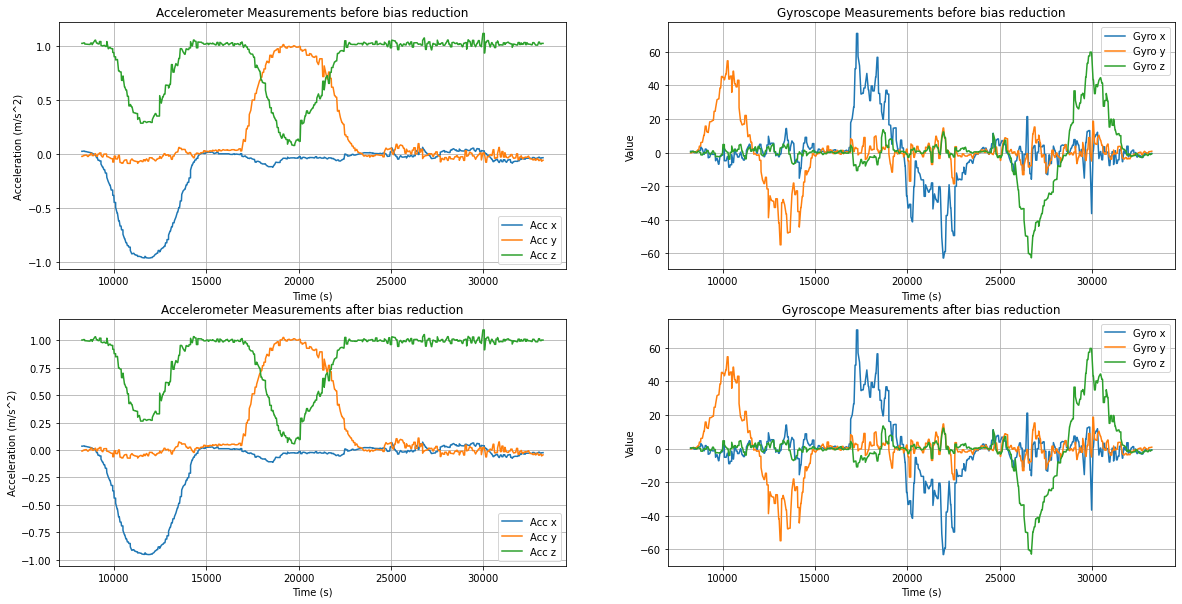

In [1401]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.grid()
plt.plot(data.time, data.accX, label='Acc x')
plt.plot(data.time, data.accY, label='Acc y')
plt.plot(data.time, data.accZ, label='Acc z')
plt.title('Accelerometer Measurements before bias reduction')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()

plt.subplot(2, 2, 3)
plt.grid()
plt.plot(prepared_data.time, prepared_data.accX, label='Acc x')
plt.plot(prepared_data.time, prepared_data.accY, label='Acc y')
plt.plot(prepared_data.time, prepared_data.accZ, label='Acc z')
plt.title('Accelerometer Measurements after bias reduction')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()

plt.subplot(2, 2, 2)
plt.grid()
plt.plot(data.time, data.gyroX, label='Gyro x')
plt.plot(data.time, data.gyroY, label='Gyro y')
plt.plot(data.time, data.gyroZ, label='Gyro z')
plt.title('Gyroscope Measurements before bias reduction')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()

plt.subplot(2, 2, 4)
plt.grid()
plt.plot(prepared_data.time, prepared_data.gyroX, label='Gyro x')
plt.plot(prepared_data.time, prepared_data.gyroY, label='Gyro y')
plt.plot(prepared_data.time, prepared_data.gyroZ, label='Gyro z')
plt.title('Gyroscope Measurements after bias reduction')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()

In [1402]:
# MAG
mag = prepared_data[['magX', 'magY', 'magZ']].to_numpy()

# ACC
G = 9.81
acc = prepared_data[['accX', 'accY', 'accZ']].to_numpy() * G

# GYRO - zamiana na radiany
gyro = (prepared_data[['gyroX', 'gyroY', 'gyroZ']].to_numpy()) / 180 * np.pi


# MAG FIELD
mag_mean = mag[:init_time].mean(axis=0)
mag_norm = mag_mean / np.linalg.norm(mag_mean)
mag_norm = mag_norm[:, np.newaxis] 

# VAR
mag_var = mag[:init_time].var(axis=0)
acc_var = acc[:init_time].var(axis=0)
gyro_var = gyro[:init_time].var(axis=0)

# NOISE
mag_noise = 10 * np.linalg.norm(mag_var)
acc_noise = 10 * np.linalg.norm(acc_var)
gyro_noise = 10 * np.linalg.norm(gyro_var)

# 
gravity = acc[:init_time].mean(axis=0)
gravity =  - gravity[:, np.newaxis]
gravity_0 = np.linalg.norm(gravity)

prepared_data['time'] = data['time']
prepared_data.to_csv(out_path)
mag_var

array([1.60318467, 0.14421433, 0.27106715])

In [1403]:
kf = Kalman(dt, gravity, mag_norm, gravity_0, acc_noise, gyro_noise, mag_noise, acc_var, gyro_var, mag_var)

In [1404]:
accX_data = []
accY_data = []
accZ_data = []
gyroX_data = []
gyroY_data = []
gyroZ_data = []
magX_data = []
magY_data = []
magZ_data = []
roll_data = []
pitch_data = []
yaw_data = []

current_frame = 0
number_of_samples = prepared_data.shape[0]

print("ORIGINAL GYRO:", gyro[0])

while current_frame < number_of_samples:

    accX_data.append(acc[0][0])
    accY_data.append(acc[1][0])
    accZ_data.append(acc[2][0])
    gyroX_data.append(gyro[0][0])
    gyroY_data.append(gyro[1][0])
    gyroZ_data.append(gyro[2][0])
    magX_data.append(mag[0][0])
    magY_data.append(mag[1][0])
    magZ_data.append(mag[2][0])

    # print("Frame: ", current_frame, " - ", acc[current_frame])

    (acc_temp, gyro_temp, mag_temp) = acc[current_frame], gyro[current_frame], normalize_array(mag[current_frame])

    kf.propagate(gyro_temp)
    kf.update(acc_temp, mag_temp)

    (roll, pitch, yaw) = get_euler_angles(kf.q)
    roll_data.append(roll)
    pitch_data.append(pitch)
    yaw_data.append(yaw)

    current_frame += 1

df = pd.DataFrame()
df['accX'] = accX_data
df['accY'] = accY_data
df['accZ'] = accZ_data
df['gyroX'] = gyroX_data
df['gyroY'] = gyroY_data
df['gyroZ'] = gyroZ_data
df['magX'] = magX_data
df['magY'] = magY_data
df['magZ'] = magZ_data
df['roll'] = roll_data
df['pitch'] = pitch_data
df['yaw'] = yaw_data
df.to_csv(calc_path)
df

ORIGINAL GYRO: [ 0.00804039 -0.00217271  0.00277212]
F_t: [[ 1.00000000e+00 -1.74823874e-04  4.72416176e-05 -6.02747250e-05]
 [ 1.74823874e-04  1.00000000e+00  6.02747250e-05  4.72416176e-05]
 [-4.72416176e-05 -6.02747250e-05  1.00000000e+00  1.74823874e-04]
 [ 6.02747250e-05 -4.72416176e-05 -1.74823874e-04  1.00000000e+00]]
q: [[ 9.99999982e-01]
 [ 1.74823870e-04]
 [-4.72416168e-05]
 [ 6.02747239e-05]]
F_t: [[ 1.00000000e+00 -1.74823874e-04  4.72416176e-05 -6.02747250e-05]
 [ 1.74823874e-04  1.00000000e+00  6.02747250e-05  4.72416176e-05]
 [-4.72416176e-05 -6.02747250e-05  1.00000000e+00  1.74823874e-04]
 [ 6.02747250e-05 -4.72416176e-05 -1.74823874e-04  1.00000000e+00]]
q: [[9.99999069e-01]
 [8.96182734e-04]
 [1.02314615e-03]
 [1.11260942e-04]]
F_t: [[ 1.00000000e+00 -1.61541697e-04 -1.40226815e-04 -1.98029869e-04]
 [ 1.61541697e-04  1.00000000e+00  1.98029869e-04 -1.40226815e-04]
 [ 1.40226815e-04 -1.98029869e-04  1.00000000e+00  1.61541697e-04]
 [ 1.98029869e-04  1.40226815e-04 -1.

,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ,roll,pitch,yaw
0,0.345223,0.345223,0.364843,0.00804,0.00804,0.00743,21.939253,22.524235,22.524235,0.082660,0.122657,0.005956
1,0.345223,0.345223,0.364843,0.00804,0.00804,0.00743,21.939253,22.524235,22.524235,0.140793,0.197943,0.025797
2,0.345223,0.345223,0.364843,0.00804,0.00804,0.00743,21.939253,22.524235,22.524235,0.161399,0.291961,0.080736
3,0.345223,0.345223,0.364843,0.00804,0.00804,0.00743,21.939253,22.524235,22.524235,0.180616,0.379163,0.124438
4,0.345223,0.345223,0.364843,0.00804,0.00804,0.00743,21.939253,22.524235,22.524235,0.166604,0.460943,0.146258
...,...,...,...,...,...,...,...,...,...,...,...,...
570,0.345223,0.345223,0.364843,0.00804,0.00804,0.00743,21.939253,22.524235,22.524235,1.277054,-2.506218,-12.636900
571,0.345223,0.345223,0.364843,0.00804,0.00804,0.00743,21.939253,22.524235,22.524235,1.335530,-2.436429,-12.695862
572,0.345223,0.345223,0.364843,0.00804,0.00804,0.00743,21.939253,22.524235,22.524235,1.390318,-2.370988,-12.754713
573,0.345223,0.345223,0.364843,0.00804,0.00804,0.00743,21.939253,22.524235,22.524235,1.474758,-2.282597,-12.832420


In [1405]:
sensor_data  = pd.read_csv(out_path)
time = sensor_data['time']
# sensor_data

In [1406]:
# num_steps = len(acc_measurements)
# dt = 0.01
# time_steps = np.arange(0, num_steps * dt, dt)
# len(time_steps)

0       8267.488
1       8313.232
2       8346.271
3       8412.517
4       8425.046
         ...    
570    33036.279
571    33069.310
572    33135.567
573    33148.095
574    33228.703
Name: time, Length: 575, dtype: float64
[[ 3.51909308e-02 -8.86873508e-03  1.00158473e+00]
 [ 3.51909308e-02 -8.86873508e-03  1.00158473e+00]
 [ 3.71909308e-02 -8.68735084e-04  1.00558473e+00]
 ...
 [-2.78090692e-02 -3.88687351e-02  9.96584726e-01]
 [-2.48090692e-02 -5.38687351e-02  1.00158473e+00]
 [-2.38090692e-02 -4.38687351e-02  1.00158473e+00]]


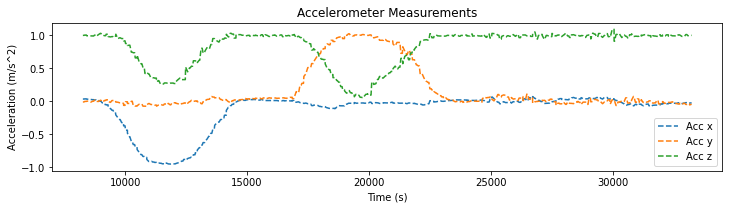

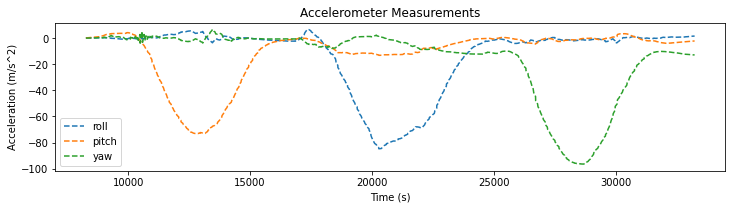

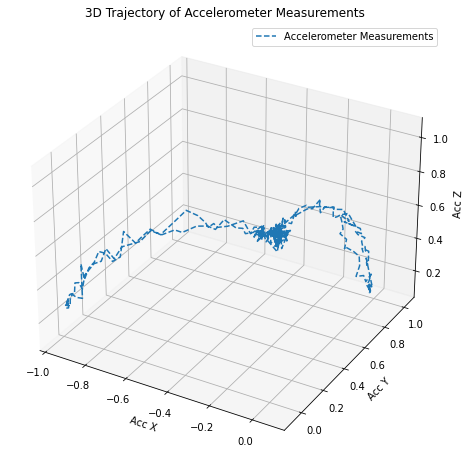

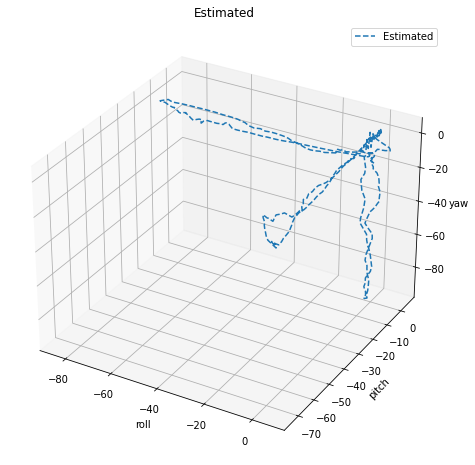

In [1407]:
# # Extract true quaternion components
time = sensor_data['time']
print(time)
acc_measurements = sensor_data[['accX', 'accY', 'accZ']].values
print(acc_measurements)
# gyro_measurements = sensor_data[['gyroX', 'gyroY', 'gyroZ']].values
# mag_measurements = sensor_data[['magX', 'magY', 'magZ']].values

# for i in range(num_steps):
#     # gyro_measurement = gyro_measurements[i, :]
#     acc_measurement = acc_measurements[i, :]
#     # mag_measurement = mag_measurements[i, :]


# # # Plot the results
# time_steps = np.arange(0, num_steps * dt, dt)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, acc_measurements[:, 0], label='Acc x', linestyle='--')
plt.plot(time, acc_measurements[:, 1], label='Acc y', linestyle='--')
plt.plot(time, acc_measurements[:, 2], label='Acc z', linestyle='--')
plt.title('Accelerometer Measurements')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()


plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, df['roll'], label='roll', linestyle='--')
plt.plot(time, df['pitch'], label='pitch', linestyle='--')
plt.plot(time, df['yaw'], label='yaw', linestyle='--')
plt.title('Accelerometer Measurements')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()

# Plot the 3D trajectory of accelerometer measurements
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(acc_measurements[:, 0], acc_measurements[:, 1], acc_measurements[:, 2], label='Accelerometer Measurements', linestyle='--')
ax.set_xlabel('Acc X')
ax.set_ylabel('Acc Y')
ax.set_zlabel('Acc Z')
ax.set_title('3D Trajectory of Accelerometer Measurements')
ax.legend()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(df['roll'], df['pitch'], df['yaw'], label='Estimated', linestyle='--')
ax.set_xlabel('roll')
ax.set_ylabel('pitch')
ax.set_zlabel('yaw')
ax.set_title('Estimated')
ax.legend()

plt.show()

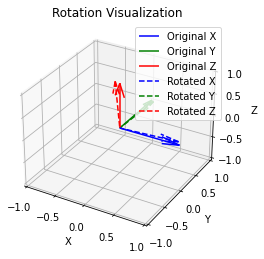

In [1408]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Replace these angles with your actual roll, pitch, and yaw values
roll_angle = df['roll'][170]  # in degrees
pitch_angle = df['pitch'][170]  # in degrees
yaw_angle = df['roll'][170]  # in degrees

# Convert angles to radians
roll_angle_rad = np.radians(roll_angle)
pitch_angle_rad = np.radians(pitch_angle)
yaw_angle_rad = np.radians(yaw_angle)

# Define rotation matrix
rotation_matrix = np.array([
    [np.cos(yaw_angle_rad) * np.cos(pitch_angle_rad),
     -np.sin(yaw_angle_rad) * np.cos(roll_angle_rad) + np.cos(yaw_angle_rad) * np.sin(pitch_angle_rad) * np.sin(roll_angle_rad),
     np.sin(yaw_angle_rad) * np.sin(roll_angle_rad) + np.cos(yaw_angle_rad) * np.sin(pitch_angle_rad) * np.cos(roll_angle_rad)],
    [np.sin(yaw_angle_rad) * np.cos(pitch_angle_rad),
     np.cos(yaw_angle_rad) * np.cos(roll_angle_rad) + np.sin(yaw_angle_rad) * np.sin(pitch_angle_rad) * np.sin(roll_angle_rad),
     -np.cos(yaw_angle_rad) * np.sin(roll_angle_rad) + np.sin(yaw_angle_rad) * np.sin(pitch_angle_rad) * np.cos(roll_angle_rad)],
    [-np.sin(pitch_angle_rad),
     np.cos(pitch_angle_rad) * np.sin(roll_angle_rad),
     np.cos(pitch_angle_rad) * np.cos(roll_angle_rad)]
])

# Generate a set of points in 3D space
points = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

# Apply rotation to the points
rotated_points = np.dot(rotation_matrix, points.T).T

# Plot the original and rotated points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(0, 0, 0, points[0, 0], points[0, 1], points[0, 2], color='b', label='Original X')
ax.quiver(0, 0, 0, points[1, 0], points[1, 1], points[1, 2], color='g', label='Original Y')
ax.quiver(0, 0, 0, points[2, 0], points[2, 1], points[2, 2], color='r', label='Original Z')
ax.quiver(0, 0, 0, rotated_points[0, 0], rotated_points[0, 1], rotated_points[0, 2], color='b', linestyle='dashed', label='Rotated X')
ax.quiver(0, 0, 0, rotated_points[1, 0], rotated_points[1, 1], rotated_points[1, 2], color='g', linestyle='dashed', label='Rotated Y')
ax.quiver(0, 0, 0, rotated_points[2, 0], rotated_points[2, 1], rotated_points[2, 2], color='r', linestyle='dashed', label='Rotated Z')

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Rotation Visualization')
ax.legend()

plt.show()
